In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('gdrive/MyDrive')
os.getcwd()

'/content/gdrive/MyDrive'

In [ ]:
os.listdir(os.path.join(os.getcwd(), "hdf5"))

['trainfeatures.hdf5', 'testfeatures.hdf5', 'Output']

In [ ]:
from imutils import paths
import glob

In [ ]:
dataset_path = "hdf5/trainfeatures.hdf5"
path_test = "hdf5/testfeatures.hdf5"
model_path = "hdf5/Output/dogs_vs_cats.hdf5"

In [ ]:
from keras.utils import np_utils
import numpy as np
import h5py

class HDF5DatasetGenerator:

	def __init__(self, dbPath, batchSize, preprocessors=None,
		aug=None, binarize=True, classes=2, mode="train"):
		# store the batch size, preprocessors, and data augmentor,
		# whether or not the labels should be binarized, along with
		# the total number of classes
		self.batchSize = batchSize
		self.preprocessors = preprocessors
		self.aug = aug
		self.binarize = binarize
		self.classes = classes
		self.startindex = 0
		self.endindex = 0
		self.numImages = 0

		# open the HDF5 database for reading and determine the total
		# number of entries in the database
		self.db = h5py.File(dbPath)
		if mode == "train":
			self.startindex = 0
			self.endindex = int(self.db["labels"].shape[0] * 0.75)
			self.numImages = int(self.db["labels"].shape[0] * 0.75)

		elif mode == "val":
			self.startindex = int(self.db["labels"].shape[0] * 0.75)
			self.endindex = self.db["labels"].shape[0]
			self.numImages = self.endindex - self.startindex
		
		else:
			self.startindex = 0
			self.endindex = self.db["labels"].shape[0]
			self.numImages = self.db["labels"].shape[0]
		
		print(self.startindex, self.endindex, self.numImages)


	def generator(self, passes=np.inf):
		epochs=0
		while epochs<passes:
			for i in np.arange(self.startindex, self.endindex, self.batchSize):
				images = self.db["features"][i:i+self.batchSize]
				labels = self.db["labels"][i:i+self.batchSize]

				if self.binarize:
					labels = np_utils.to_categorical(labels, self.classes)

				if self.preprocessors is not None:
					procImages = []
					for image in images:
						for p in self.preprocessors:
							image = p.preprocess(image)
						procImages.append(image)
					images = np.array(procImages)

				if self.aug is not None:
					(images, labels) = next(self.aug.flow(images, labels, batch_size=self.batchSize))
				yield(images, labels)
			epochs = epochs+1


	def close(self):
		self.db.close()


In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import h5py
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

# open the HDF5 database for reading then determine the index of
# the training and testing split, provided that this data was
# already shuffled *prior* to writing it to disk

db = h5py.File(dataset_path, "r")
print(db.keys())

trainGen = HDF5DatasetGenerator(dataset_path, 128, classes=2, mode="train")
valGen = HDF5DatasetGenerator(dataset_path, 128, classes=2, mode="val")

# define our simple neural network

# define our simple neural network
model = Sequential()
model.add(Dense(512, kernel_regularizer=l2(0.002), input_shape=(7 * 7 * 2048,), activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(16, kernel_regularizer=l2(0.002), activation="relu"))
model.add(Dense(2, kernel_regularizer=l2(0.002), activation="softmax"))

# model = Sequential()
# model.add(Dense(256, kernel_regularizer=l2(0.002), input_shape=(7 * 7 * 2048,), activation="relu"))
# model.add(Dense(16, activation="relu"))
# model.add(Dense(2, activation="softmax"))
db.close()

<KeysViewHDF5 ['features', 'label_names', 'labels']>
0 18750 18750
18750 25000 6250


In [ ]:
# compile the model
opt = SGD(learning_rate=1e-3, momentum=0.9, decay=1e-3 / 25)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
valGen.numImages

6250

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(model_path, monitor="val_loss", mode="min",
                             save_best_only=True, verbose=1)
callbacks = [checkpoint]

# train the network
print("[INFO] training simple network...")
H = model.fit(trainGen.generator(),
                    steps_per_epoch=trainGen.numImages // 512,
                    validation_data=valGen.generator(),
                    validation_steps=valGen.numImages // 512,
                    epochs=25,
                    max_queue_size=512 * 2, 
                    callbacks=callbacks,
                    verbose=1)

[INFO] training simple network...
Epoch 1/25
36/36 [==============================] - 106s 3s/step - loss: 2.1955 - accuracy: 0.9531 - val_loss: 2.0911 - val_accuracy: 0.9850

Epoch 00001: val_loss improved from inf to 2.09113, saving model to hdf5/Output/dogs_vs_cats.hdf5
Epoch 2/25
36/36 [==============================] - 135s 4s/step - loss: 2.0876 - accuracy: 0.9876 - val_loss: 2.0909 - val_accuracy: 0.9837

Epoch 00002: val_loss improved from 2.09113 to 2.09087, saving model to hdf5/Output/dogs_vs_cats.hdf5
Epoch 3/25
36/36 [==============================] - 122s 3s/step - loss: 2.0822 - accuracy: 0.9863 - val_loss: 2.0862 - val_accuracy: 0.9831

Epoch 00003: val_loss improved from 2.09087 to 2.08623, saving model to hdf5/Output/dogs_vs_cats.hdf5
Epoch 4/25
36/36 [==============================] - 80s 2s/step - loss: 2.0737 - accuracy: 0.9859 - val_loss: 2.0626 - val_accuracy: 0.9855

Epoch 00004: val_loss improved from 2.08623 to 2.06259, saving model to hdf5/Output/dogs_vs_cats.

In [ ]:
trainGen.close()
valGen.close()

In [ ]:
from keras.models import load_model
model = load_model(model_path)

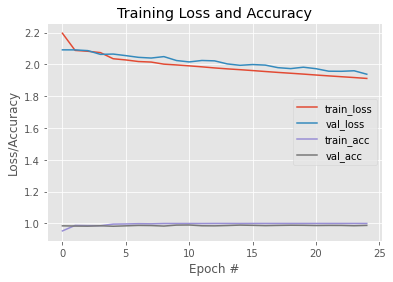

In [ ]:
import matplotlib.pyplot as plt

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 25), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 25), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# make predictions on the testing images, finding the index of the
# label with the corresponding largest predicted probability, then
# show a nicely formatted classification report
db_test = h5py.File(path_test, "r")
print(db_test.keys())
print(db_test["labels"][:10])

In [ ]:
testGen = HDF5.DatasetGenerator(path_test, 50, classes=2, binarize=False, mode="test")
print(testGen.numImages)

0 12500 12500
12500


In [ ]:
print("[INFO] evaluating network...")
predictions = model.predict(testGen.generator(), 
                                      steps=testGen.numImages // 50, max_queue_size=50 * 2)

[INFO] evaluating network...


In [ ]:
pred = list(predictions.argmax(axis=1))
print(len(predictions))
print(predictions)

12500
[[2.7437835e-16 1.0000000e+00]
 [2.4044999e-23 1.0000000e+00]
 [1.2195361e-16 1.0000000e+00]
 ...
 [6.0840534e-16 1.0000000e+00]
 [3.1093317e-21 1.0000000e+00]
 [1.0000000e+00 4.2522822e-16]]


In [ ]:
pred[0:10]

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

In [ ]:
print(db_test["labels"][:10])
print(testGen.db["labels"][:10])
print(pred[:10])

In [ ]:
db_test.close()
testGen.close()

NameError: ignored

In [ ]:
print(len(pred))

12500


In [ ]:
pred_prob_dog = list(predictions[:,1])

In [ ]:
pred_prob_dog[0:10]

[1.0,
 1.0,
 1.0,
 1.0,
 4.338473e-21,
 3.968588e-15,
 5.9288723e-24,
 3.8290492e-16,
 3.976223e-16,
 1.3795204e-14]

In [ ]:
index = [i+1 for i in range (12500)]

In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['id', 'label'])

In [ ]:
df['id'] = index

In [ ]:
df['label'] = pred_prob_dog

In [ ]:
df.head(15)

,id,label
0,1,1.000000e+00
1,2,1.000000e+00
2,3,1.000000e+00
3,4,1.000000e+00
4,5,4.338473e-21
5,6,3.968588e-15
6,7,5.928872e-24
7,8,3.829049e-16
8,9,3.976223e-16
9,10,1.379520e-14


In [ ]:
df.to_csv('results_kernel.csv', index=False)